In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='seaborn-v0_8-colorblind'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='black', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [6]:
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")

df = robberies_in_boston.Count

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


/home/stan/deeplearn/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


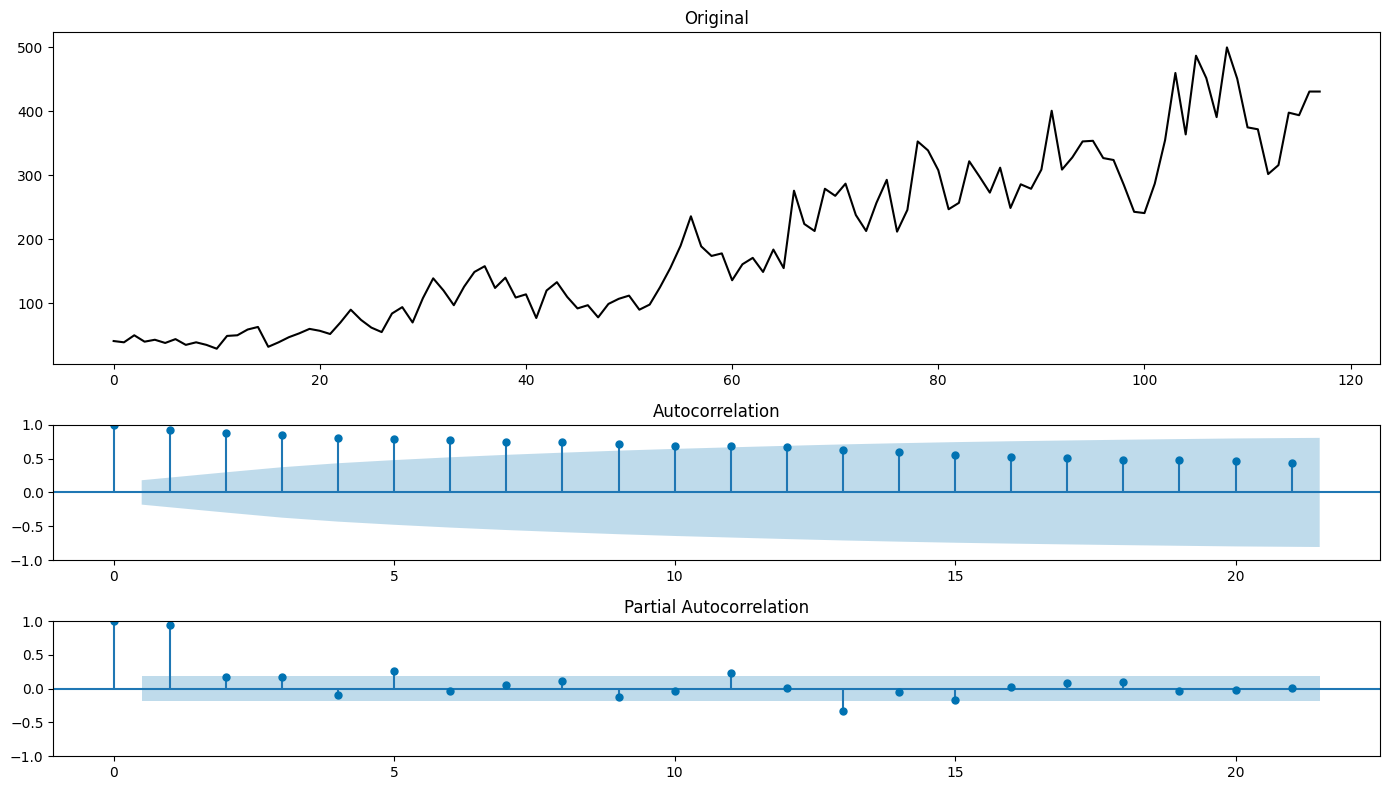

In [7]:
tsplot(df)

Временной ряд нестационарен. Приведем его к стационарному виду:

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


/home/stan/deeplearn/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


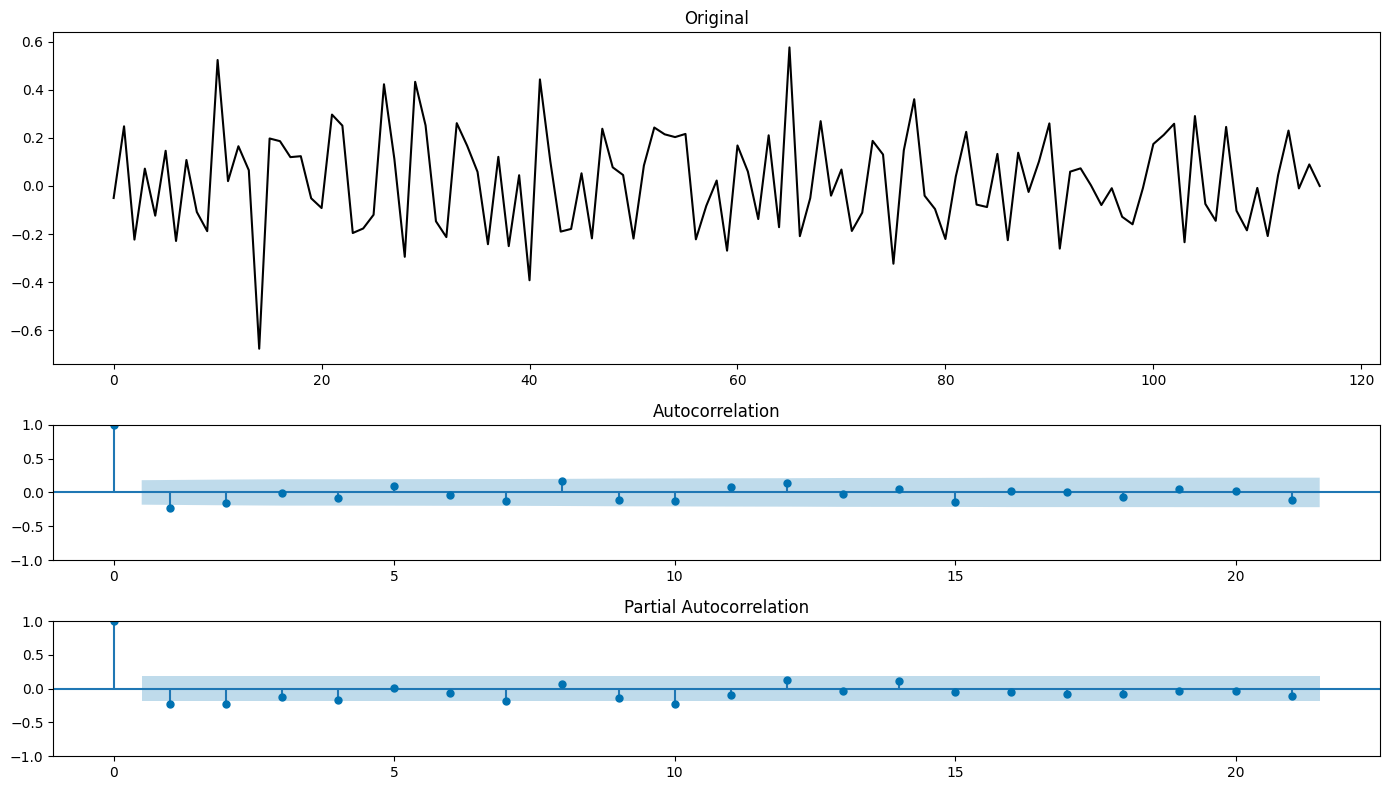

In [9]:
#Box-cox+дифференцирование
df_st = np.diff(boxcox(df, 0), 1)
tsplot(df_st)

Используем разные техники работы с рядами

## Скользящее среднее (MA)

In [10]:
def ma(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [11]:
@interact

def ma_test_nonstat(frame=(1, 60, 5)):
    with plt.style.context('seaborn-v0_8-colorblind'):
        plt.figure(figsize=(14, 8))
        plt.plot(df, color='black',label='Исходный ряд')
        plt.title("Скользящее среднее на нестационарном ряду")
        ma_test = ma(df, frame)
        plt.plot(ma_test, color='red', linewidth='1', label=f'Скользящее среднее с фреймом {frame}')
        plt.legend()   

interactive(children=(IntSlider(value=26, description='frame', max=60, min=1, step=5), Output()), _dom_classes…

In [12]:
@interact
def ma_test_stat(frame=(1, 60, 5)):
    with plt.style.context('seaborn-v0_8-colorblind'):
        plt.figure(figsize=(14, 8))
        plt.plot(df_st, color='black',label='Исходный ряд')
        plt.title("Скользящее среднее на стационарном ряду")
        ma_test = ma(df_st, frame)
        plt.plot(ma_test, color='red', linewidth='1', label=f'Скользящее среднее с фреймом {frame}')
        plt.legend()   

interactive(children=(IntSlider(value=26, description='frame', max=60, min=1, step=5), Output()), _dom_classes…

В случае стационарного ряда - MA при широком фрейме стремится к прямой
В случае нестационарного ряда - MA стремится к тренду

In [13]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

/tmp/ipykernel_25098/1731674567.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)


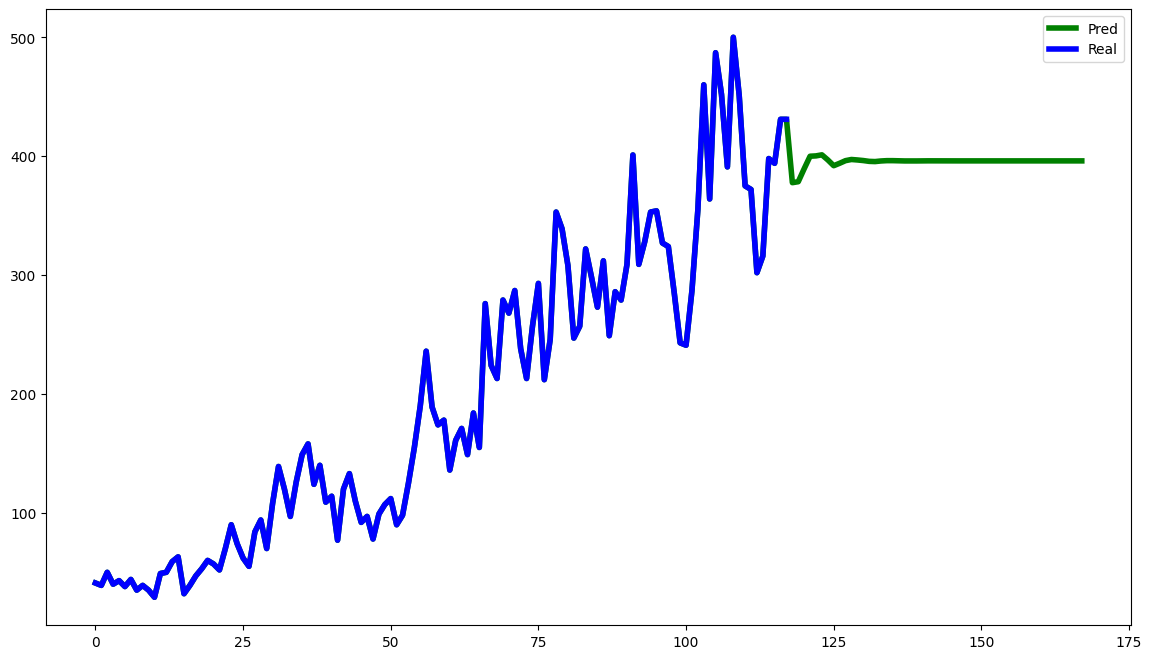

In [30]:
series_pred = predict(df, 7, 50)

with plt.style.context('seaborn-v0_8-colorblind'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(df, color='blue', linewidth='4', label='Real')
    plt.legend()

/tmp/ipykernel_25098/1731674567.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)


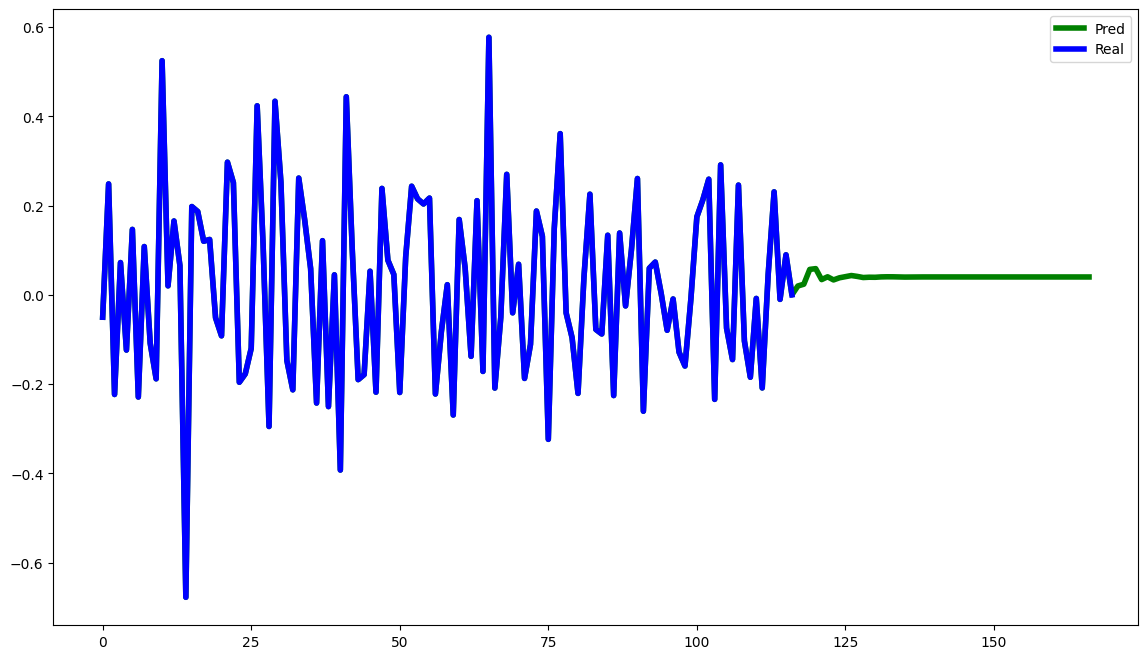

In [31]:
series_pred_st = predict(pd.DataFrame(df_st), 7, 50)

with plt.style.context('seaborn-v0_8-colorblind'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred_st, color='green', linewidth='4', label='Pred')
    plt.plot(df_st, color='blue', linewidth='4', label='Real')
    plt.legend()

## Взвешенное скользящее среднее (WMA)

In [26]:
def wma(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [33]:
@interact
def wma_test_non_stat(w=[[1,1,2,3,5,8,13],[1,2,3,4,5,6,7],[1,2,4,8,16,32,64]]):
    with plt.style.context('seaborn-v0_8-colorblind'):
        plt.figure(figsize=(20, 8))
        plt.plot(df, color='black',label='Исходный ряд')
        plt.title("Взвешенное скользящее среднее на нестационарном ряду")
        wma_test = wma(df, 7, w)
        plt.plot(wma_test, color='red', linewidth='1', label='Взвешенное скользящее среднее')
        plt.legend()
        plt.show()

interactive(children=(Dropdown(description='w', options=([1, 1, 2, 3, 5, 8, 13], [1, 2, 3, 4, 5, 6, 7], [1, 2,…

In [32]:
@interact
def wma_test_stat(w=[[1,1,2,3,5,8,13],[1,2,3,4,5,6,7],[1,2,4,8,16,32,64]]):
    with plt.style.context('seaborn-v0_8-colorblind'):
        plt.figure(figsize=(20, 8))
        plt.plot(df_st, color='black',label='Исходный ряд')
        plt.title("Взвешенное скользящее среднее на стационарном ряду")
        wma_test = wma(df_st, 7, w)
        plt.plot(wma_test, color='red', linewidth='1', label='Взвешенное скользящее среднее')
        plt.legend()
        plt.show()

interactive(children=(Dropdown(description='w', options=([1, 1, 2, 3, 5, 8, 13], [1, 2, 3, 4, 5, 6, 7], [1, 2,…

В целом WMA дает лучший результат, чем MA

# Экспоненциальное сглаживание

In [34]:
def ema(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [35]:
@interact
def ema_non_stat(alpha=(0, 1, 0.1)):
    with plt.style.context('seaborn-v0_8-colorblind'):
        plt.figure(figsize=(20, 8))
        plt.plot(df, color='black',label='Исходный ряд')
        plt.title("Экспоненциальное сглаживание на нестационарном ряду")
        ema_test = ema(df, alpha)
        plt.plot(ema_test, color='red', linewidth='1', label='Экспоненциальное сглаживание')
        plt.legend()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

In [36]:
@interact
def ema_stat(alpha=(0, 1, 0.1)):
    with plt.style.context('seaborn-v0_8-colorblind'):
        plt.figure(figsize=(20, 8))
        plt.plot(df_st, color='black',label='Исходный ряд')
        plt.title("Экспоненциальное сглаживание на стационарном ряду")
        ema_test = ema(df_st, alpha)
        plt.plot(ema_test, color='red', linewidth='1', label='Экспоненциальное сглаживание')
        plt.legend()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

## Приближение для нестационарного ряда

In [38]:
train, val = df[:100], df[100:]

In [37]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [39]:
def double_ema_forecast(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True)


def dema_mse_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = double_ema_forecast(pd.Series(train_split), alpha, beta, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [40]:
opt_dema = minimize(dema_mse_cross_val, x0=[0.0,0.0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt_dema, beta_opt_dema = opt_dema.x
opt_dema

/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True)
/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True)
/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True)
/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True)
/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.app

      fun: 0.9999999999997957
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.43582932e-05, 0.00000000e+00])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 1
     njev: 10
   status: 0
  success: True
        x: array([2.66552687e-07, 0.00000000e+00])

In [41]:
def plot_dema(alpha, beta, series, series_to_plot, n_preds):
    dema = double_ema_forecast(pd.Series(series), alpha, beta, n_preds)
    with plt.style.context('seaborn-v0_8-colorblind'):
        plt.figure(figsize=(20, 8))
        plt.plot(series_to_plot, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True)


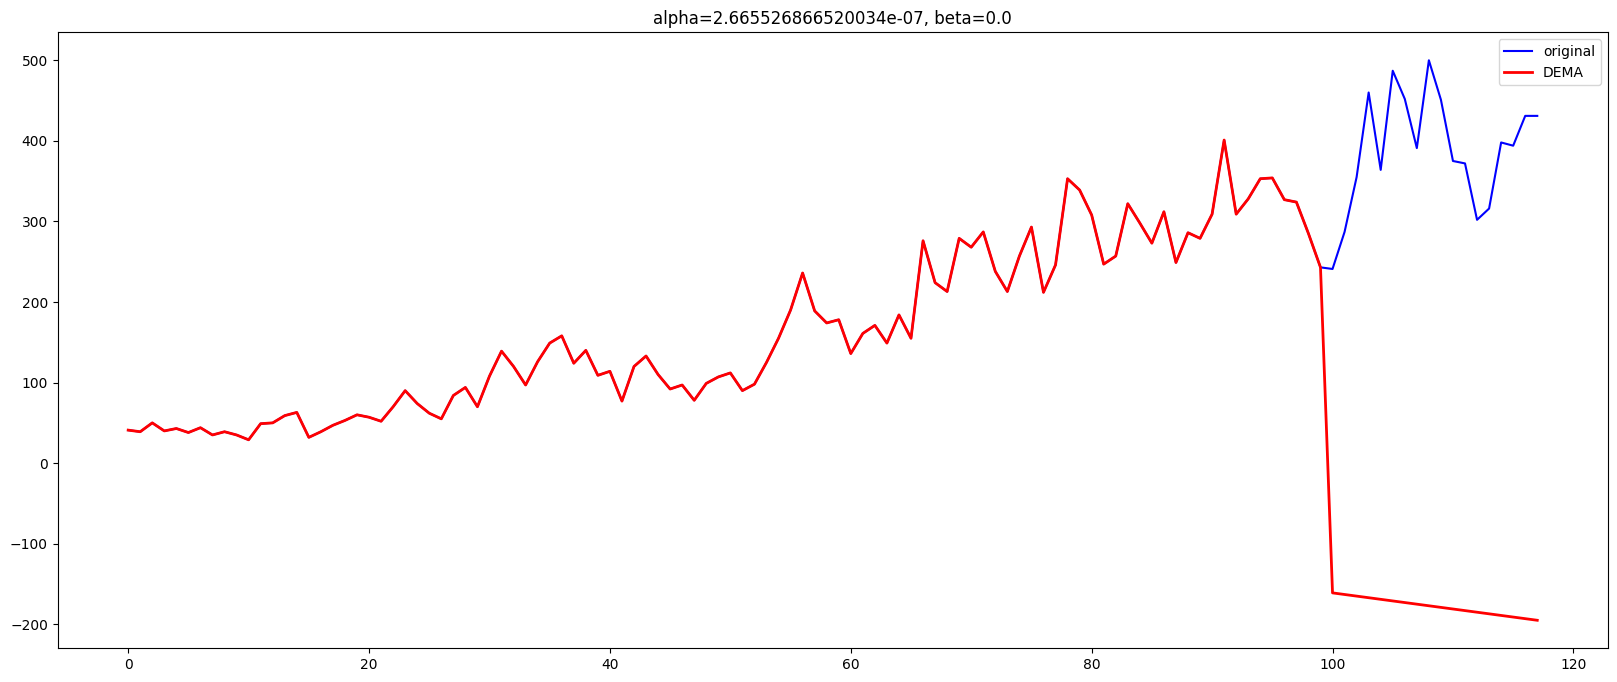

In [42]:
plot_dema(alpha_opt_dema, beta_opt_dema, train, df, len(val))

/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True)
/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True)
/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True)
/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True)
/tmp/ipykernel_25098/3698848758.py:18: FutureWarning: The series.app

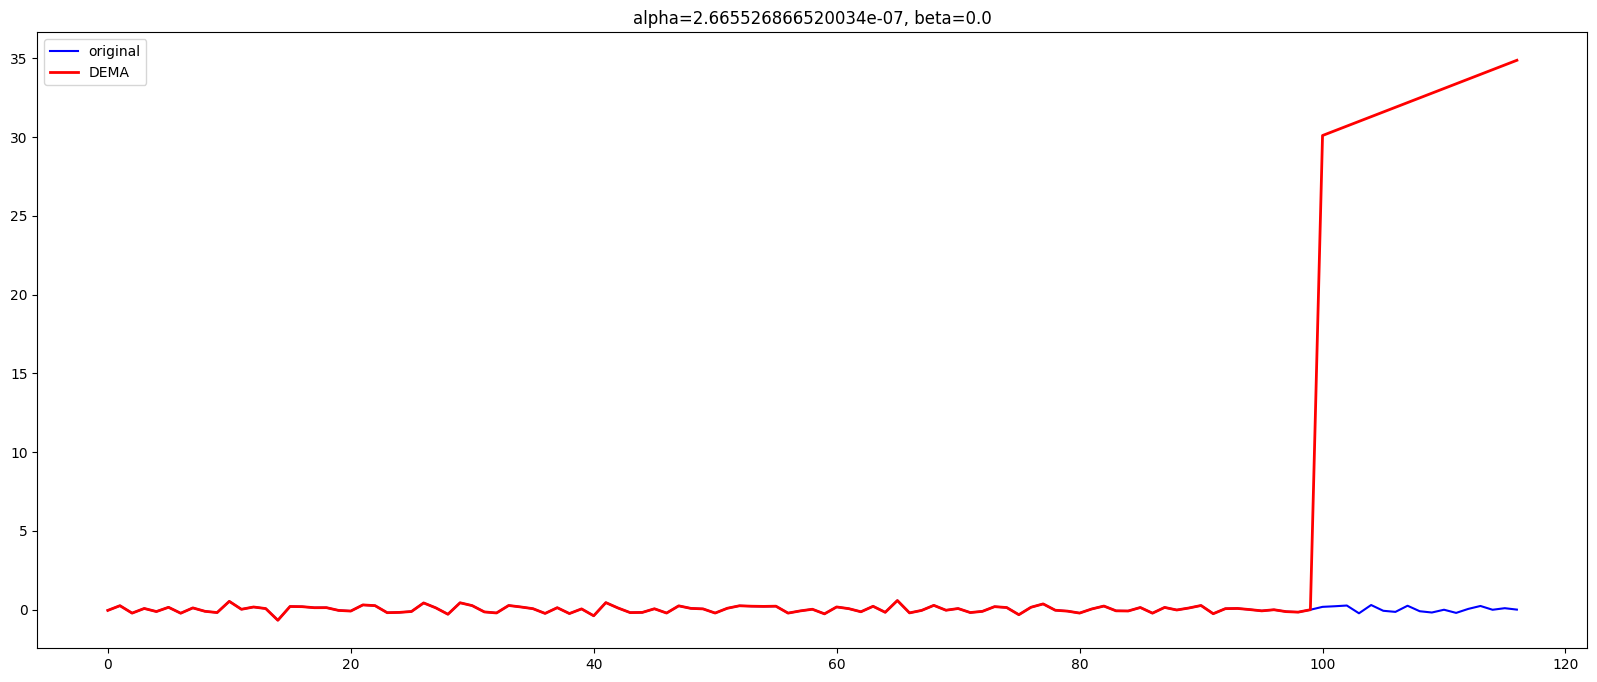

In [46]:
train, val = df_st[:100], df_st[100:]

opt_dema = minimize(dema_mse_cross_val, x0=[0.0,0.0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt_dema, beta_opt_dema = opt_dema.x
opt_dema
plot_dema(alpha_opt_dema, beta_opt_dema, train, df_st, len(val))

Экспоненциальное сглаживание не дает адекватного приближения ни для нестационарного, ни для стационарного рядов

In [52]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(series[i+season_len] - series[i]) / season_len
    return sum / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result


def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

## Хольт-Винтерс для нестационарного ряда

In [53]:
train, val = df[:100], df[100:]

@interact
def tema_test(alpha=(0, 1, 0.05), beta=(0, 1, 0.05), gamma=(0, 1, 0.05)):
    plot_tema(alpha, beta, gamma, train, df, len(val))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), FloatSlider(value=0.0, …

In [55]:
train, test = df[:80], df[20:]

def tema_mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
        predictions = result[-len(test):]
        error = mean_squared_error(predictions, test)
        errors.append(error)

    return np.mean(np.array(errors))

In [58]:
opt_tema = minimize(tema_mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt_tema, beta_opt_tema, gamma_opt_tema = opt_tema.x
print(opt_tema)


      fun: 5062.187419402859
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.01911631e+00, -3.11959410e+01,  9.23650250e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 30
     njev: 40
   status: 0
  success: True
        x: array([2.4533132e-04, 1.0000000e+00, 0.0000000e+00])


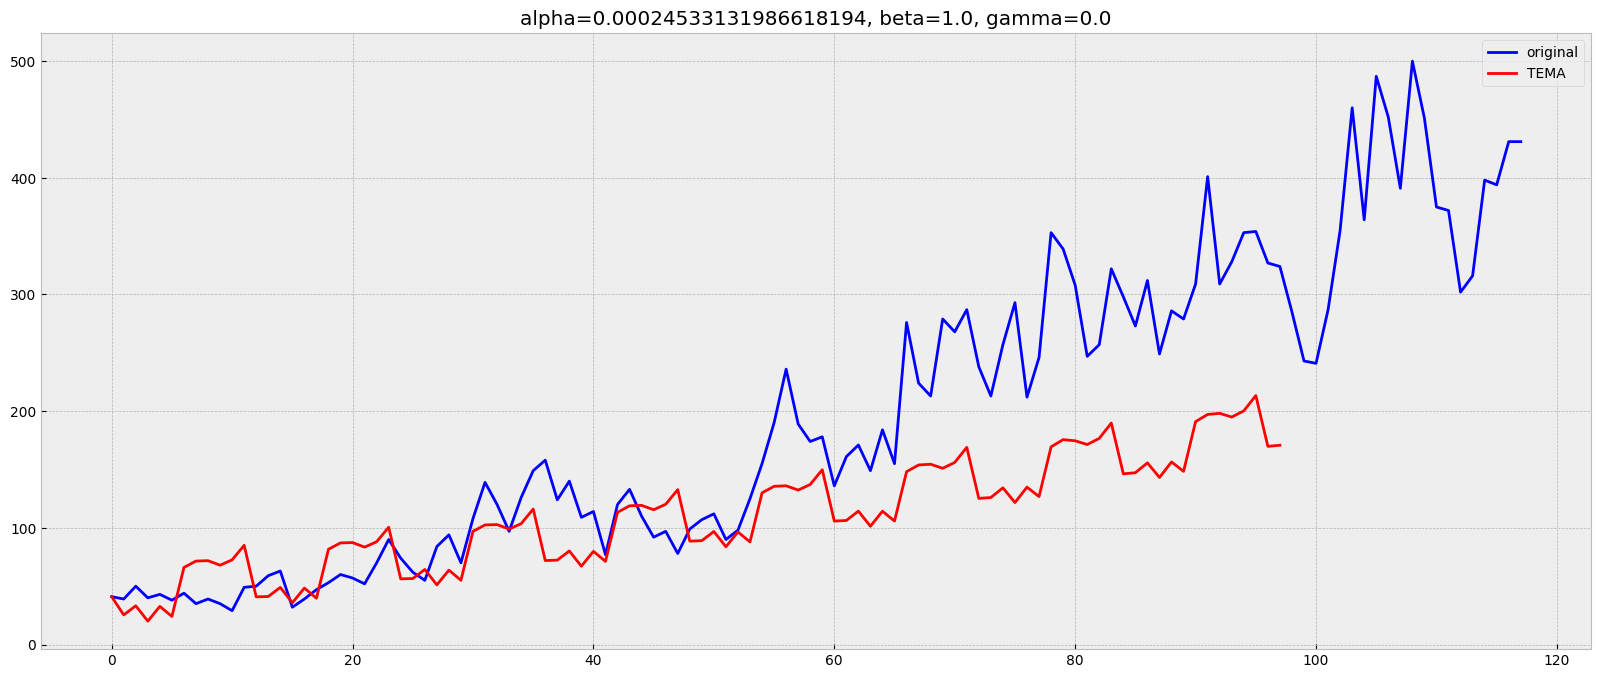

In [60]:
plot_tema(alpha_opt_tema, beta_opt_tema, gamma_opt_tema, train, df, len(val))